# *Salix* and *Populus* sequence capture: nucleotide diversity

Brian J. Sanderson

Last updated: 7 May 2020

Required R libraries: tidyverse, cowplot, stringr, viridisLite, gplots, corrplot

Other required programs: [site_degeneracy.py](https://github.com/BrianSanderson/phylo-seq-cap/blob/master/scripts/site_degeneracy.py), [calculate_pi.py](https://github.com/BrianSanderson/phylo-seq-cap/blob/master/scripts/calculate_pi.py)

---

This analysis notebook describes the plotting of distributions of nucleotide diversity, following from the results of notebook titled [*Salix* and *Populus* sequence capture: quantifying sequence variation](https://github.com/BrianSanderson/phylo-seq-cap/blob/master/notebooks/Phylo_Trial_03_Variants.ipynb).

## Characterize base degeneracy for phylogeny target sequences

I wrote the script [site_degeneracy.py](https://github.com/BrianSanderson/phylo-seq-cap/blob/master/scripts/site_degeneracy.py) to characterize the base degeneracy (0, 2, 3, 4-fold) of each site in the target sequences FASTA file. It returns a tab-delimited text file.

```bash
python site_degeneracy.py --fasta phyloTargets.fasta --output site_details.tsv
```

## Calculate nucleotide diversity from filtered VCF

I wrote the script [calculate_pi.py](https://github.com/BrianSanderson/phylo-seq-cap/blob/master/scripts/calculate_pi.py) to calculate values of nucleotide diversity as Nei's &pi;. This script calculates &pi; for genotypes that are supported by $\ge$ 2 reads for each allele (e.g. both alleles in a heterozygous call must have $\ge$ 2 reads), and returns NA values when this condition isn't met.

**Note**: because the VCF is read line-by-line, the number of variants needs to be provided when the script is called to have an informative ETA in the progress bar. If the number of variants is not provided it will still provide a progress bar, but it is counting up rather than counting down.

**Note**: I used bcftools mpileup rather than GATK because I wanted to have the non-variant sites (and their associated depths) included in the VCF for calculating &pi; so I could distinguish missing data (exclude from &pi; calculation) from sites with appropriate depth but no variation (include with &pi; calculation). This can be quickly found with [vcftools](https://vcftools.github.io/index.html).

```bash
python calculate_pi.py -v phyloTargets.mpileup.filtered.DP.nocall.vcf.gz -o phyloTargets.pi --num_vcf 2366493
```

## Remove the 'Sapur-' prefix from both files

This is, again, a hold-over from the HybPiper analysis because we began with the alignments from that analysis. This should be the last we need to deal with this.

```bash
sed -i 's/Sapur\-//g' phyloTargets.pi
sed -i 's/Sapur\-//g' site_details.tsv
```

## Summarize and plot values of Nei's &pi; in R

In [1]:
suppressMessages(library('cowplot'))
suppressMessages(library('viridisLite'))
suppressMessages(library('lemon'))
suppressMessages(library('tidyverse'))
suppressMessages(library(corrplot))

Combine the ```phyloTargets.pi``` and ```site_details.tsv``` files

In [2]:
left_join(read_delim("phyloTargets.pi", delim = "\t") %>% rename(., PI = Pi),
          read_delim("site_details.tsv", delim = "\t") %>% mutate(., Position = Position + 1), 
          by = c("Gene" = "Gene", "Position" = "Position")) -> full_diversity

Parsed with column specification:
cols(
  Gene = col_character(),
  Position = col_double(),
  Species = col_character(),
  Pi = col_double()
)

Parsed with column specification:
cols(
  Gene = col_character(),
  Position = col_double(),
  Subs = col_double()
)



### Summarize total values of &pi; for each species

In [3]:
group_by(full_diversity, Gene, Species, Subs) %>%
summarize(., sum_pi = sum(PI, na.rm=T),
             n_sites = n(),
             na_sites = sum(is.na(PI)),
             real_sites = n_sites - na_sites,
             actual_pi = sum_pi / real_sites) %>%
mutate(., actual_pi = replace(actual_pi, is.na(actual_pi), 0)) %>%
group_by(., Species) %>%
summarize(., total_pi = mean(actual_pi))

Species,total_pi
<chr>,<dbl>
P_balsamifera,0.012991556
P_mexicana,0.012737496
P_tremula,0.016155307
S_exigua,0.005594001
S_nigra,0.009336135
S_phlebophylla,0.012530314


### Calculate &pi; at synonymous and non-synonmous sites

Using the site degeneracy table, calculate the values of &pi; across synonymous sites (all 4-fold, 2/3 of 3-fold, and 1/3 of 2-fold sites) and non-synonymous sites (all of 0-fold, 1/3 of 3-fold, and 2/3 of 2-fold sites)

In [4]:
test_diversity <- group_by(full_diversity, Gene, Species, Subs) %>%
summarize(., sum_pi = sum(PI, na.rm=T),
             n_sites = n(),
             na_sites = sum(is.na(PI)),
             real_sites = n_sites - na_sites,
             actual_pi = sum_pi / real_sites) %>%
mutate(., actual_pi = replace(actual_pi, is.na(actual_pi), 0)) %>%
group_by(., Gene, Species) %>%
summarize(., syn_sites = sum(real_sites[Subs == 4], real_sites[Subs == 3] * 2/3, real_sites[Subs == 2] * 1/3),
             non_syn_sites = sum(real_sites[Subs == 0], real_sites[Subs == 3] * 1/3, real_sites[Subs == 2] * 2/3),
             total_sites = syn_sites + non_syn_sites,
             Synonymous = sum(sum_pi[Subs == 4], sum_pi[Subs == 3] * 2/3, sum_pi[Subs == 2] * 1/3) / syn_sites,
             Nonsynonymous = sum(sum_pi[Subs == 0], sum_pi[Subs == 3] * 1/3, sum_pi[Subs == 2] * 2/3) / non_syn_sites) %>% 
select(., Gene, Species, total_sites, Synonymous, Nonsynonymous) %>%
gather(., key = "Site", value = "PI", Synonymous, Nonsynonymous) %>% mutate(., PI = replace(PI, is.na(PI), 0))

### Plot distributions of &pi;

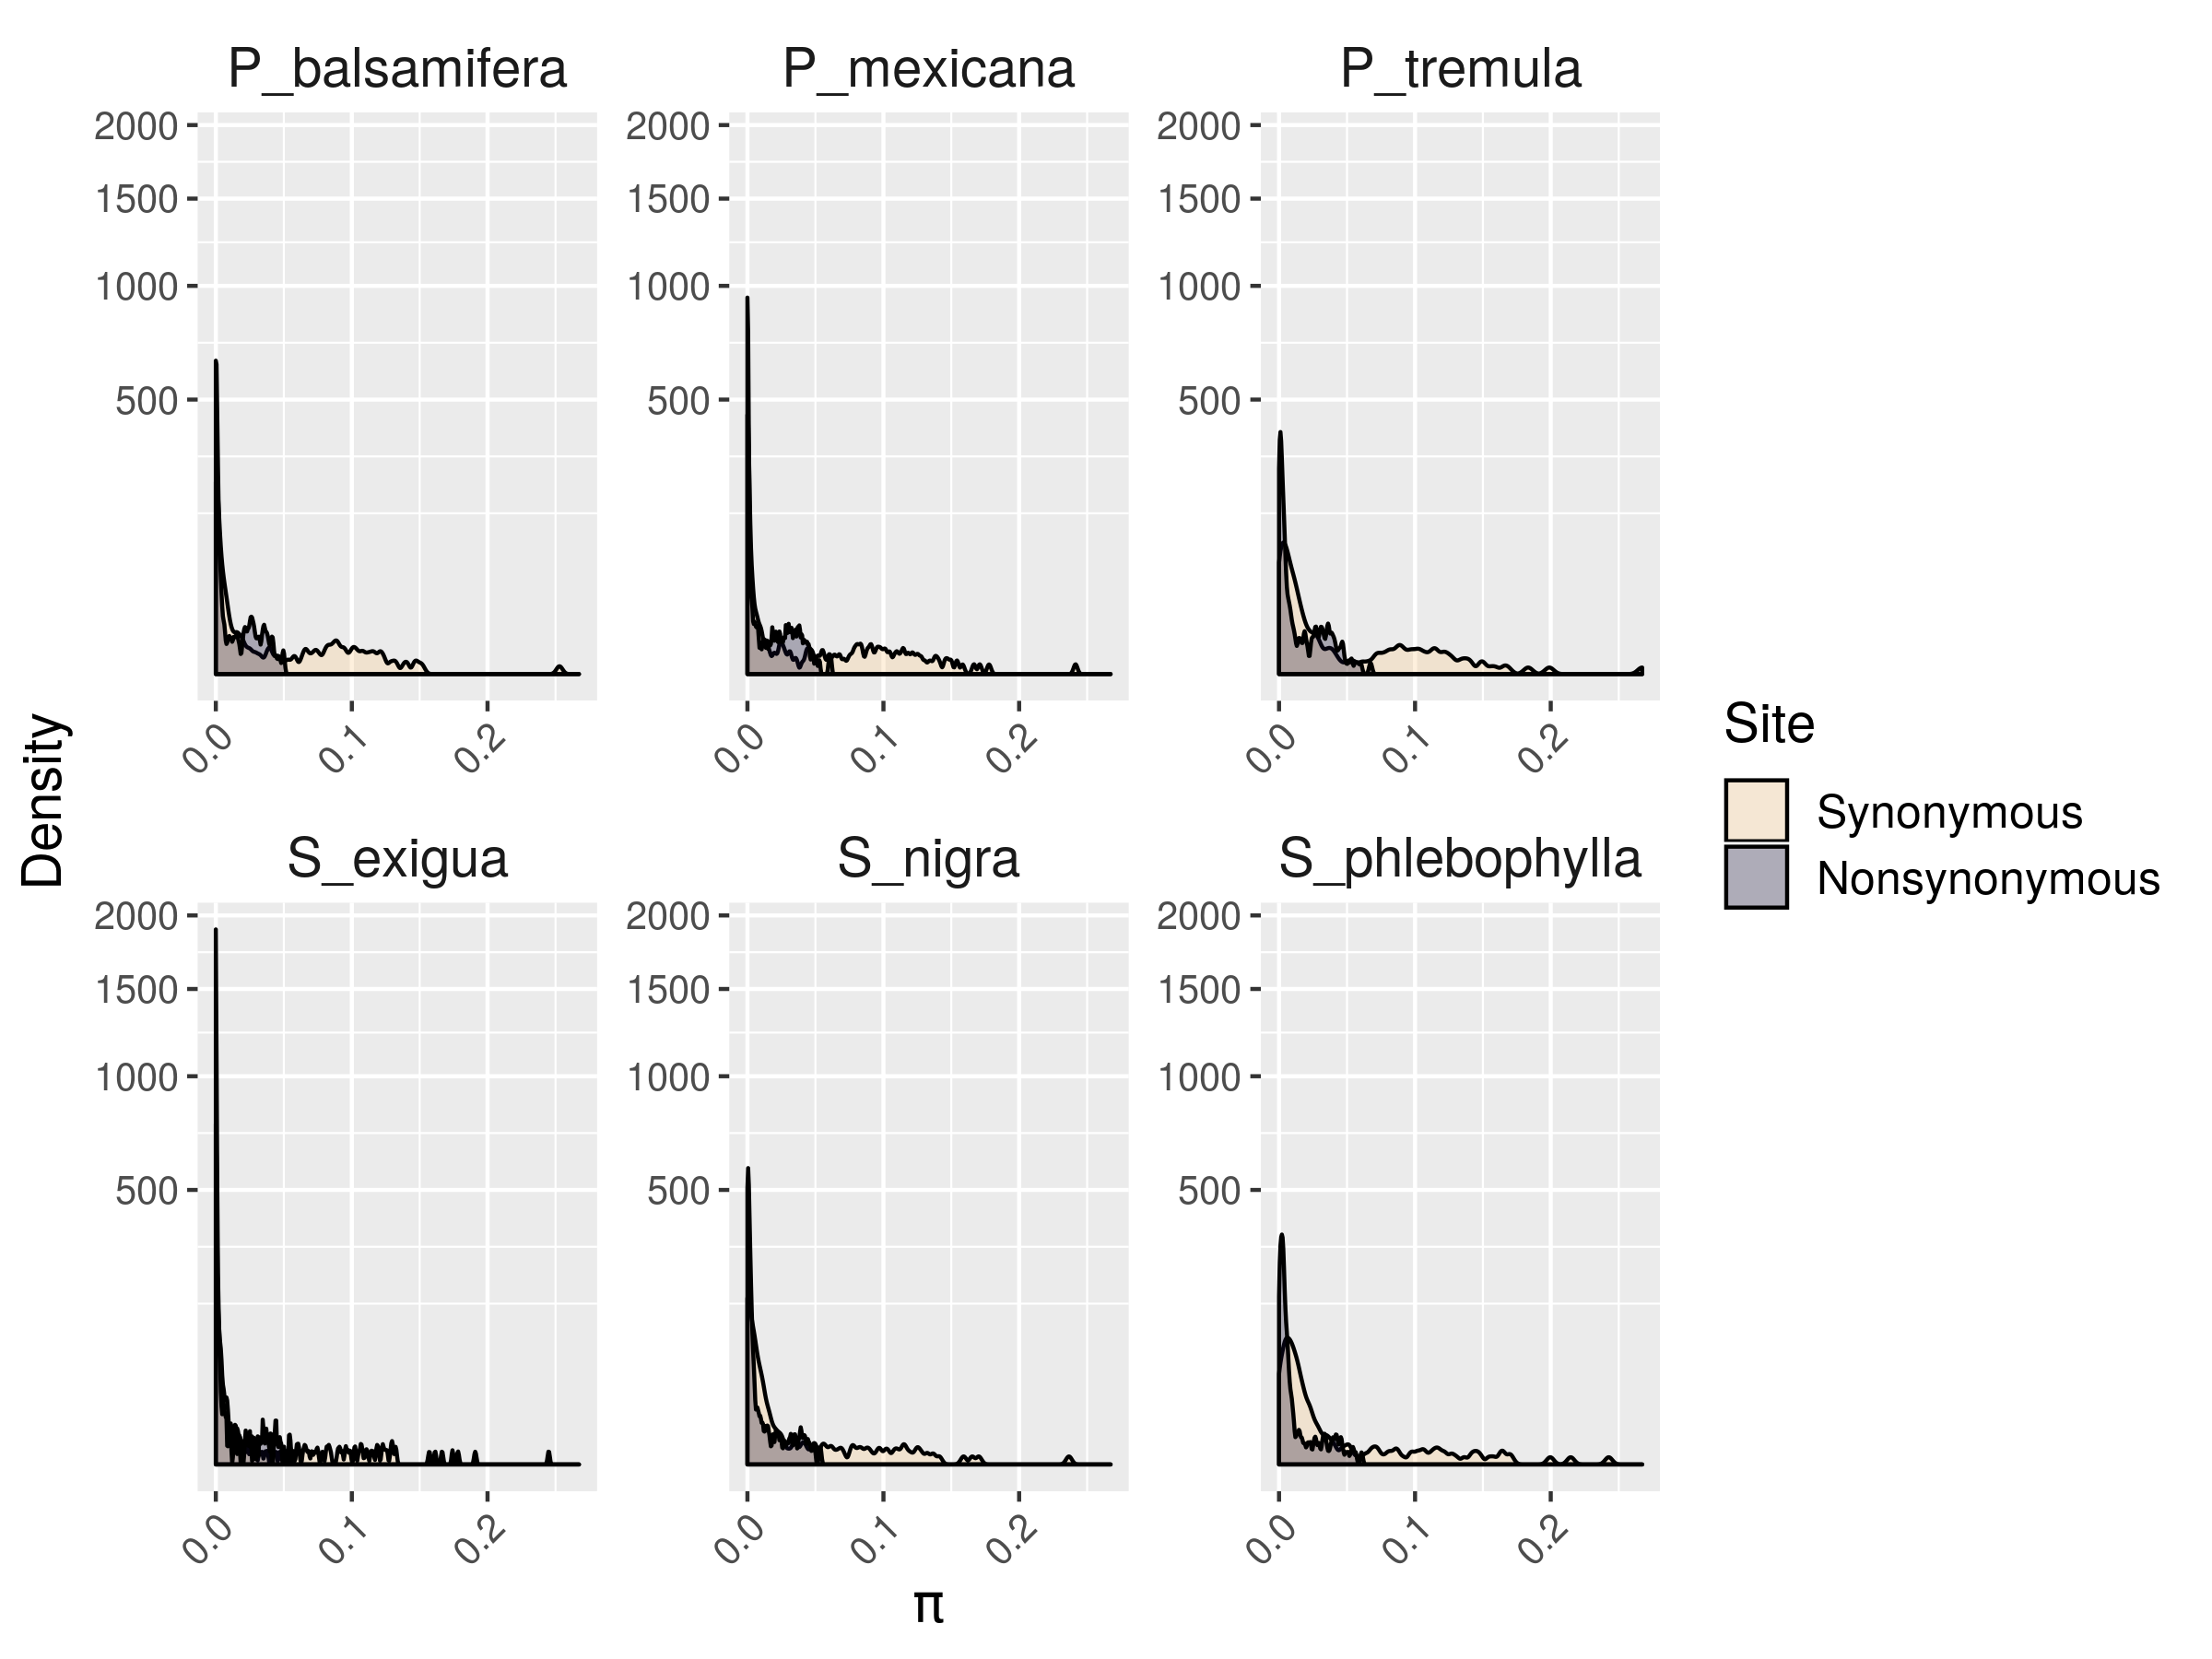

In [5]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)
mutate(test_diversity, Site = fct_relevel(Site, "Synonymous", "Nonsynonymous")) %>%
ggplot(., aes(x=PI, fill=Site)) +
                geom_density() + 
                facet_rep_wrap(Species ~ ., repeat.tick.labels = TRUE,) + 
                scale_x_continuous(trans='pseudo_log') +
                scale_y_continuous(trans='sqrt') +
                scale_fill_manual(values = magma(100, alpha=0.3)[c(90,10)]) +
                theme(strip.background = element_rect(fill="#FF000000"),
                      axis.title.x = element_text(size = 14),
                      axis.title.y = element_text(size = 14),
                      axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
                      axis.text.y = element_text(size = 10),
                      strip.text.x = element_text(size = 14),
                      legend.text = element_text(size = 12),
                      legend.title = element_text(size = 14)) +
                labs(y="Density", x=expression(pi), size = 14)

### Summarize values of &pi; by site and species

In [6]:
group_by(test_diversity, Species, Site) %>%
summarize(., mean_PI = mean(PI))

Species,Site,mean_PI
<chr>,<chr>,<dbl>
P_balsamifera,Nonsynonymous,0.005796428
P_balsamifera,Synonymous,0.017358995
P_mexicana,Nonsynonymous,0.005735093
P_mexicana,Synonymous,0.016886119
P_tremula,Nonsynonymous,0.007018854
P_tremula,Synonymous,0.021766068
S_exigua,Nonsynonymous,0.002500213
S_exigua,Synonymous,0.007454148
S_nigra,Nonsynonymous,0.004086039


### Calculate means and confidence intervals for &pi; values

This function uses a bootstrapping approach to return summary statistics for &pi; values

In [7]:
boot.mean = function(x,B,binwidth=NULL){
    n = length(x)
    boot.samples = matrix( sample(x,size=n*B,replace=TRUE), B, n)
    boot.statistics = apply(boot.samples,1,mean)
    se = sd(boot.statistics)
    require(ggplot2)
    if ( is.null(binwidth) )
        binwidth = diff(range(boot.statistics))/30
    interval = mean(x) + c(-1,1)*2*se
    return( list(boot.statistics = boot.statistics, interval=interval, se=se) )}

Use the boot.mean function to calculate means and confidence intervals for each species

In [8]:
Pobal.syn = boot.mean(test_diversity$PI[test_diversity$Species=="P_balsamifera" & 
                                        test_diversity$Site=="Synonymous"], 500)
Pobal.nonsyn = boot.mean(test_diversity$PI[test_diversity$Species=="P_balsamifera" & 
                                           test_diversity$Site=="Nonsynonymous"], 500)
Pomex.syn = boot.mean(test_diversity$PI[test_diversity$Species=="P_mexicana" & 
                                        test_diversity$Site=="Synonymous"], 500)
Pomex.nonsyn = boot.mean(test_diversity$PI[test_diversity$Species=="P_mexicana" & 
                                           test_diversity$Site=="Nonsynonymous"], 500)
Potre.syn = boot.mean(test_diversity$PI[test_diversity$Species=="P_tremula" & 
                                        test_diversity$Site=="Synonymous"], 500)
Potre.nonsyn = boot.mean(test_diversity$PI[test_diversity$Species=="P_tremula" & 
                                           test_diversity$Site=="Nonsynonymous"], 500)
Saexi.syn = boot.mean(test_diversity$PI[test_diversity$Species=="S_exigua" & 
                                        test_diversity$Site=="Synonymous"], 500)
Saexi.nonsyn = boot.mean(test_diversity$PI[test_diversity$Species=="S_exigua" & 
                                           test_diversity$Site=="Nonsynonymous"], 500)
Sanig.syn = boot.mean(test_diversity$PI[test_diversity$Species=="S_nigra" & 
                                        test_diversity$Site=="Synonymous"], 500)
Sanig.nonsyn = boot.mean(test_diversity$PI[test_diversity$Species=="S_nigra" & 
                                           test_diversity$Site=="Nonsynonymous"], 500)
Saphl.syn = boot.mean(test_diversity$PI[test_diversity$Species=="S_phlebophylla" & 
                                        test_diversity$Site=="Synonymous"], 500)
Saphl.nonsyn = boot.mean(test_diversity$PI[test_diversity$Species=="S_phlebophylla" & 
                                           test_diversity$Site=="Nonsynonymous"], 500)

Prepare a data frame for plotting that has the means and confidence intervals of &pi; values for synonymous and non-synonymous sites for all species

In [9]:
bothMeanFrame <- data.frame(rbind(c(mean(test_diversity$PI[test_diversity$Species=="P_balsamifera" & 
                                                           test_diversity$Site=="Synonymous"]),
                                    Pobal.syn$interval),
                                  c(mean(test_diversity$PI[test_diversity$Species=="P_balsamifera" & 
                                                        test_diversity$Site=="Nonsynonymous"]),
                                    Pobal.nonsyn$interval),
                                  c(mean(test_diversity$PI[test_diversity$Species=="P_mexicana" & 
                                                           test_diversity$Site=="Synonymous"]),
                                    Pomex.syn$interval),
                                  c(mean(test_diversity$PI[test_diversity$Species=="P_mexicana" & 
                                                           test_diversity$Site=="Nonsynonymous"]),
                                    Pomex.nonsyn$interval),
                                  c(mean(test_diversity$PI[test_diversity$Species=="P_tremula" & 
                                                           test_diversity$Site=="Synonymous"]),
                                    Potre.syn$interval),
                                  c(mean(test_diversity$PI[test_diversity$Species=="P_tremula" & 
                                                           test_diversity$Site=="Nonsynonymous"]),
                                    Potre.nonsyn$interval),
                                  c(mean(test_diversity$PI[test_diversity$Species=="S_nigra" & 
                                                           test_diversity$Site=="Synonymous"]),
                                    Sanig.syn$interval),
                                  c(mean(test_diversity$PI[test_diversity$Species=="S_nigra" & 
                                                           test_diversity$Site=="Nonsynonymous"]),
                                    Sanig.nonsyn$interval),
                                  c(mean(test_diversity$PI[test_diversity$Species=="S_exigua" & 
                                                           test_diversity$Site=="Synonymous"]),
                                    Saexi.syn$interval),
                                  c(mean(test_diversity$PI[test_diversity$Species=="S_exigua" & 
                                                           test_diversity$Site=="Nonsynonymous"]),
                                    Saexi.nonsyn$interval),
                                  c(mean(test_diversity$PI[test_diversity$Species=="S_phlebophylla" & 
                                                           test_diversity$Site=="Synonymous"]),
                                    Saphl.syn$interval),
                                  c(mean(test_diversity$PI[test_diversity$Species=="S_phlebophylla" & 
                                                           test_diversity$Site=="Nonsynonymous"]),
                                    Saphl.nonsyn$interval)))
colnames(bothMeanFrame) <- c("mean", "lower", "upper")
bothMeanFrame$species <- c("P_balsamifera","P_balsamifera",
                           "P_mexicana", "P_mexicana",
                           "P_tremula","P_tremula",
                           "S_nigra","S_nigra",
                           "S_exigua","S_exigua",
                           "S_phlebophylla","S_phlebophylla")
bothMeanFrame$Site <- c(rep(c("Synonymous", "Nonsynonymous"),6))
bothMeanFrame$Site <- factor(bothMeanFrame$Site, levels=c("Synonymous", "Nonsynonymous"))

Plot means and CIs of &pi;

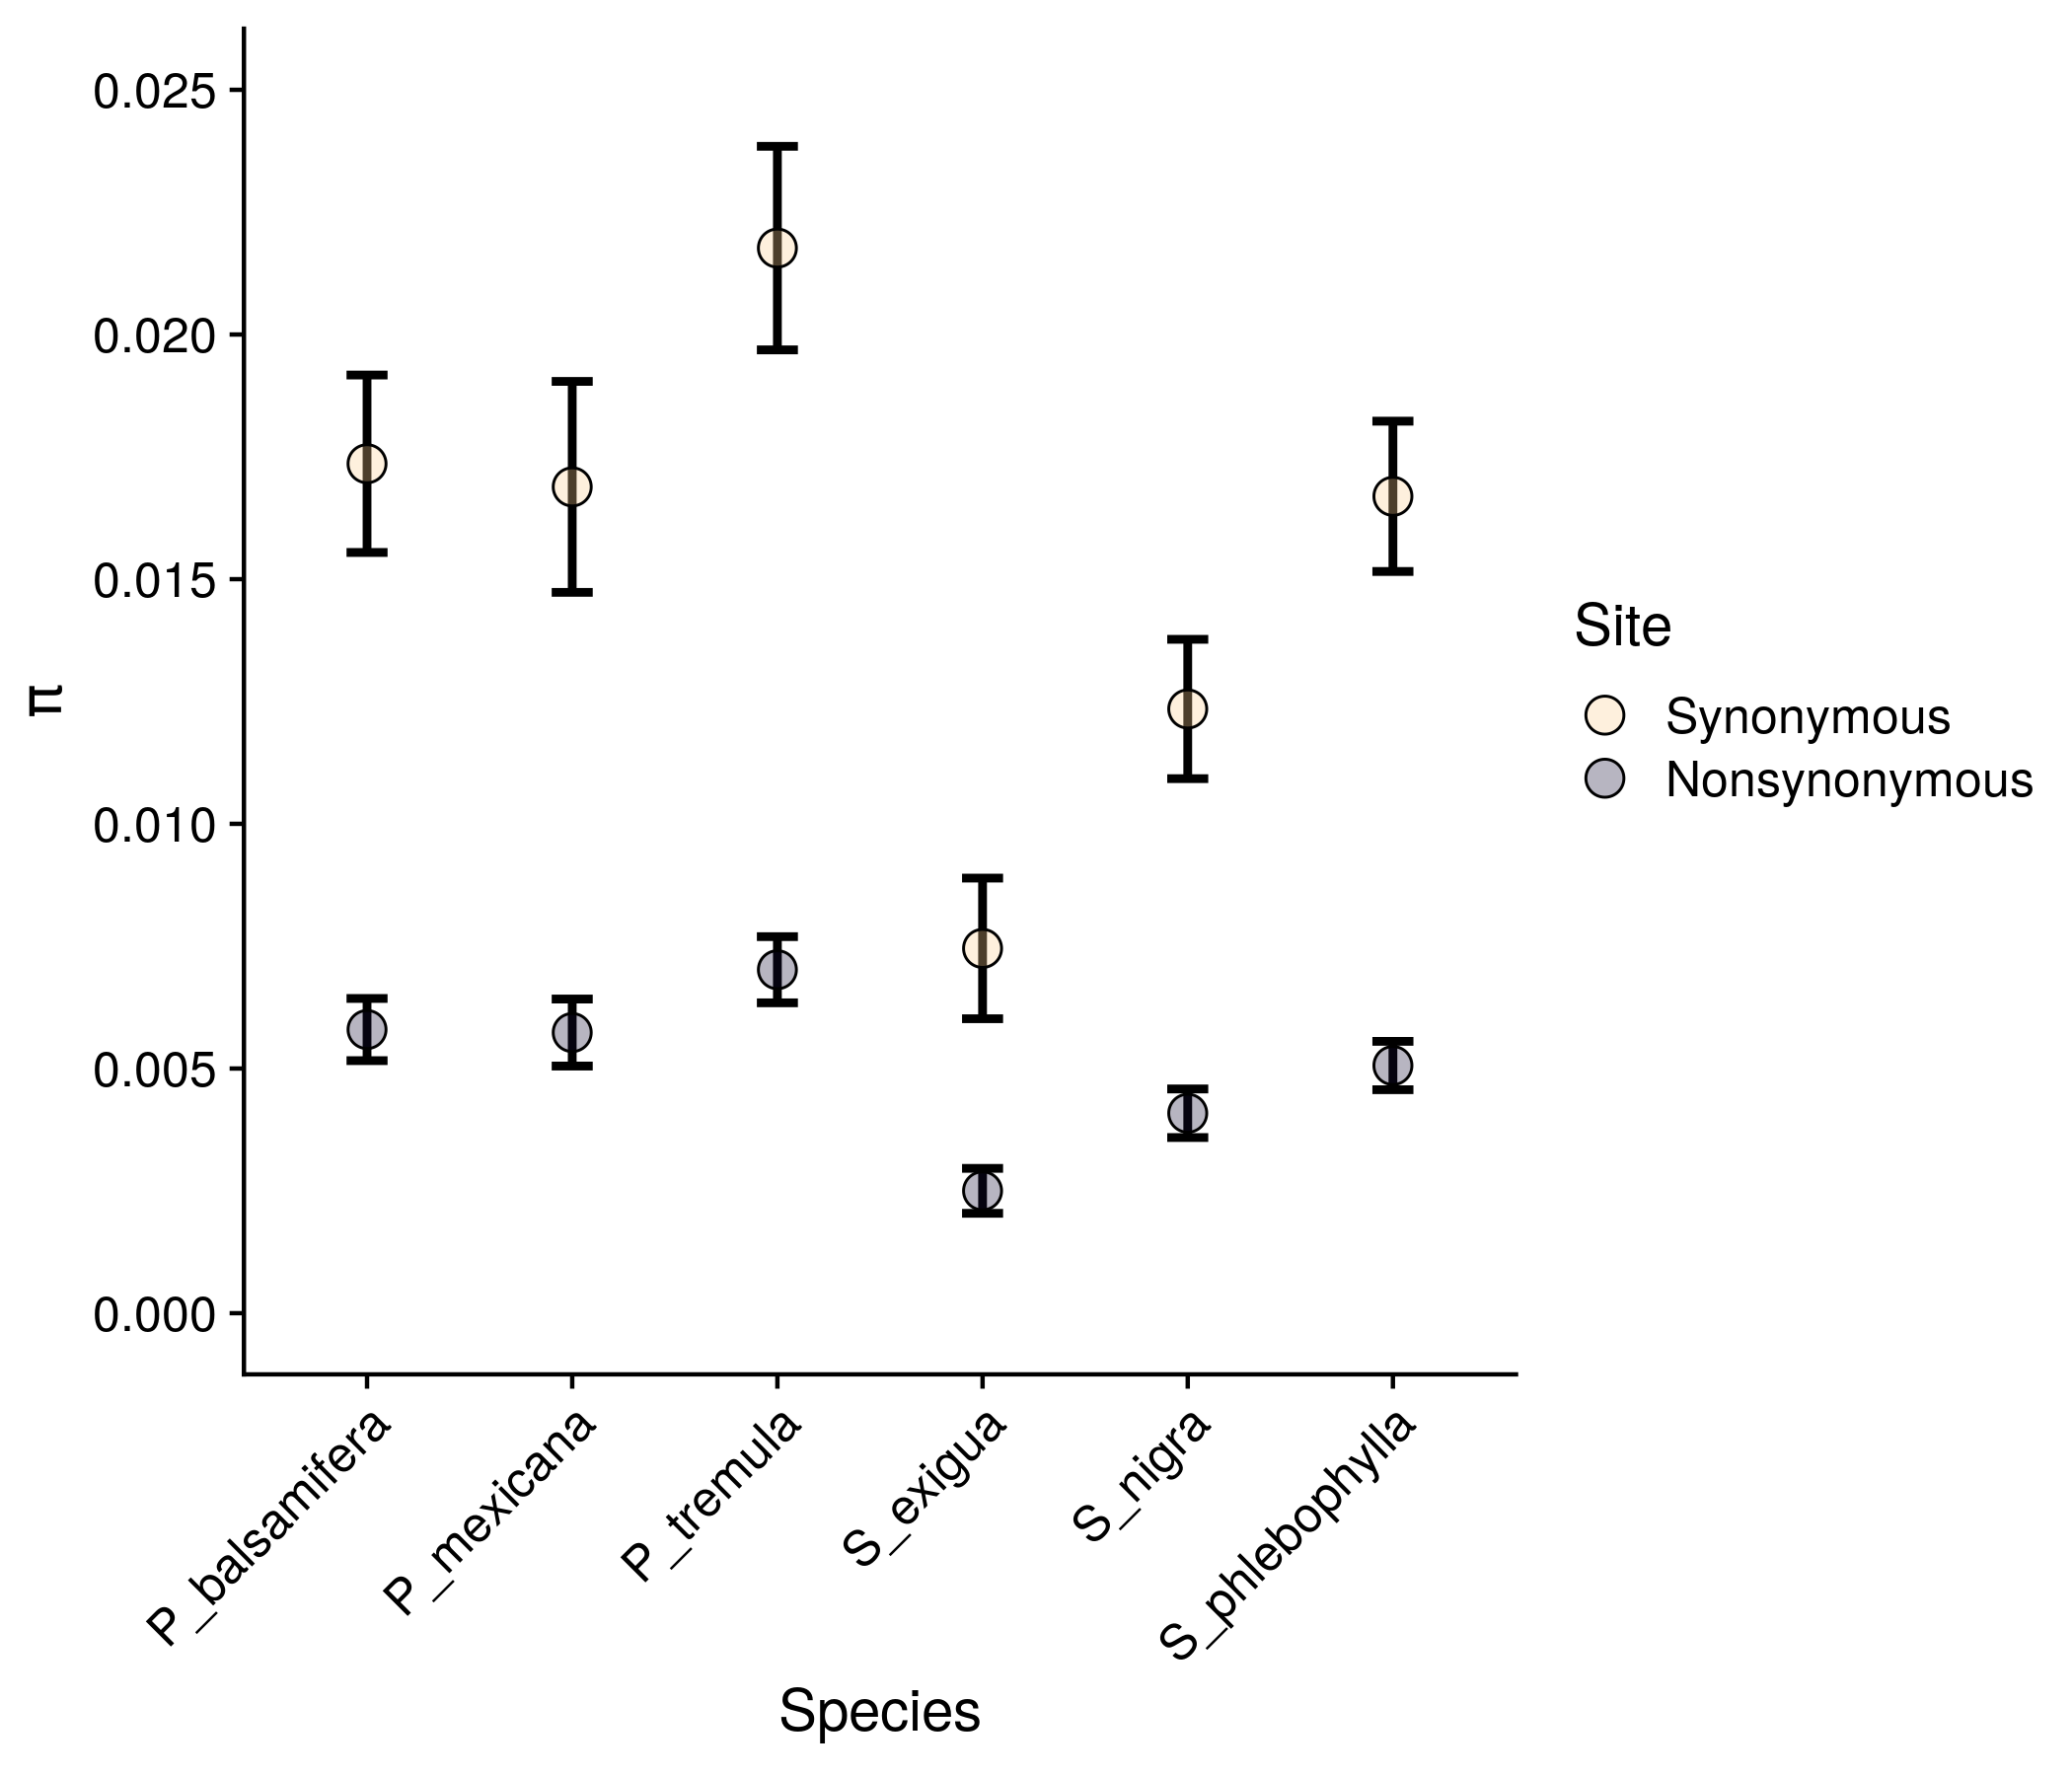

In [10]:
options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 300)
piMeans <- ggplot() + 
geom_errorbar(data=bothMeanFrame, mapping=aes(x=species,ymin=lower, ymax=upper, group=Site), width=0.2, size=1) +
scale_fill_manual(values = magma(100, alpha=0.3)[c(90,10)]) +
scale_y_continuous(breaks=c(0, 0.005, 0.01, 0.015, 0.02, 0.025), limits = c(0, 0.025)) +
theme(strip.background = element_rect(fill="#FF000000")) +
#facet_rep_wrap(species ~ ., repeat.tick.labels = TRUE,) +
geom_point(data=bothMeanFrame, mapping=aes(x=species, y=mean, fill=Site), size=4, shape=21) +
ylab(expression(pi)) +
xlab("Species") +
theme_cowplot() +
theme(axis.text.x = element_text(angle = 45, hjust = 1))
piMeans

### Look for correlations of $\pi$ values among species

Construct a matrix of site-correlations between each species for synonymous (above diagonal) and non-synonymous (below diagonal) sites)

In [11]:
piMatrix <- matrix(nrow=6, ncol=6)
row.names(piMatrix) <- c("P_balsamifera", "P_mexicana", "P_tremula", 
                         "S_exigua", "S_nigra", "S_phlebophylla")
colnames(piMatrix) <- c("P_balsamifera", "P_mexicana", "P_tremula", 
                         "S_exigua", "S_nigra", "S_phlebophylla")

In [12]:
for (i in 1:6) {
    for (j in 1:6) {
        piMatrix[j,i] = cor(test_diversity$PI[test_diversity$Species==colnames(piMatrix)[i] & 
                                              test_diversity$Site=="Synonymous"],
                            test_diversity$PI[test_diversity$Species==colnames(piMatrix)[j] & 
                                              test_diversity$Site=="Synonymous"])
        piMatrix[i,j] = cor(test_diversity$PI[test_diversity$Species==colnames(piMatrix)[i] & 
                                              test_diversity$Site=="Nonsynonymous"],
                            test_diversity$PI[test_diversity$Species==colnames(piMatrix)[j] & 
                                              test_diversity$Site=="Nonsynonymous"])
    }
}
piMatrix

,P_balsamifera,P_mexicana,P_tremula,S_exigua,S_nigra,S_phlebophylla
P_balsamifera,1.0000000,0.9327179,0.9209455,0.5377951,0.6351475,0.5665454
P_mexicana,0.9180864,1.0000000,0.9037394,0.5262796,0.6351738,0.5595400
P_tremula,0.9125635,0.8901508,1.0000000,0.5962232,0.6833114,0.6302938
S_exigua,0.4841435,0.4915694,0.5366611,1.0000000,0.8201984,0.8820917
S_nigra,0.6159090,0.6211774,0.6648939,0.8139339,1.0000000,0.8141901
S_phlebophylla,0.5457733,0.5472031,0.5984915,0.8713979,0.8011856,1.0000000


### Plot correlation matrix

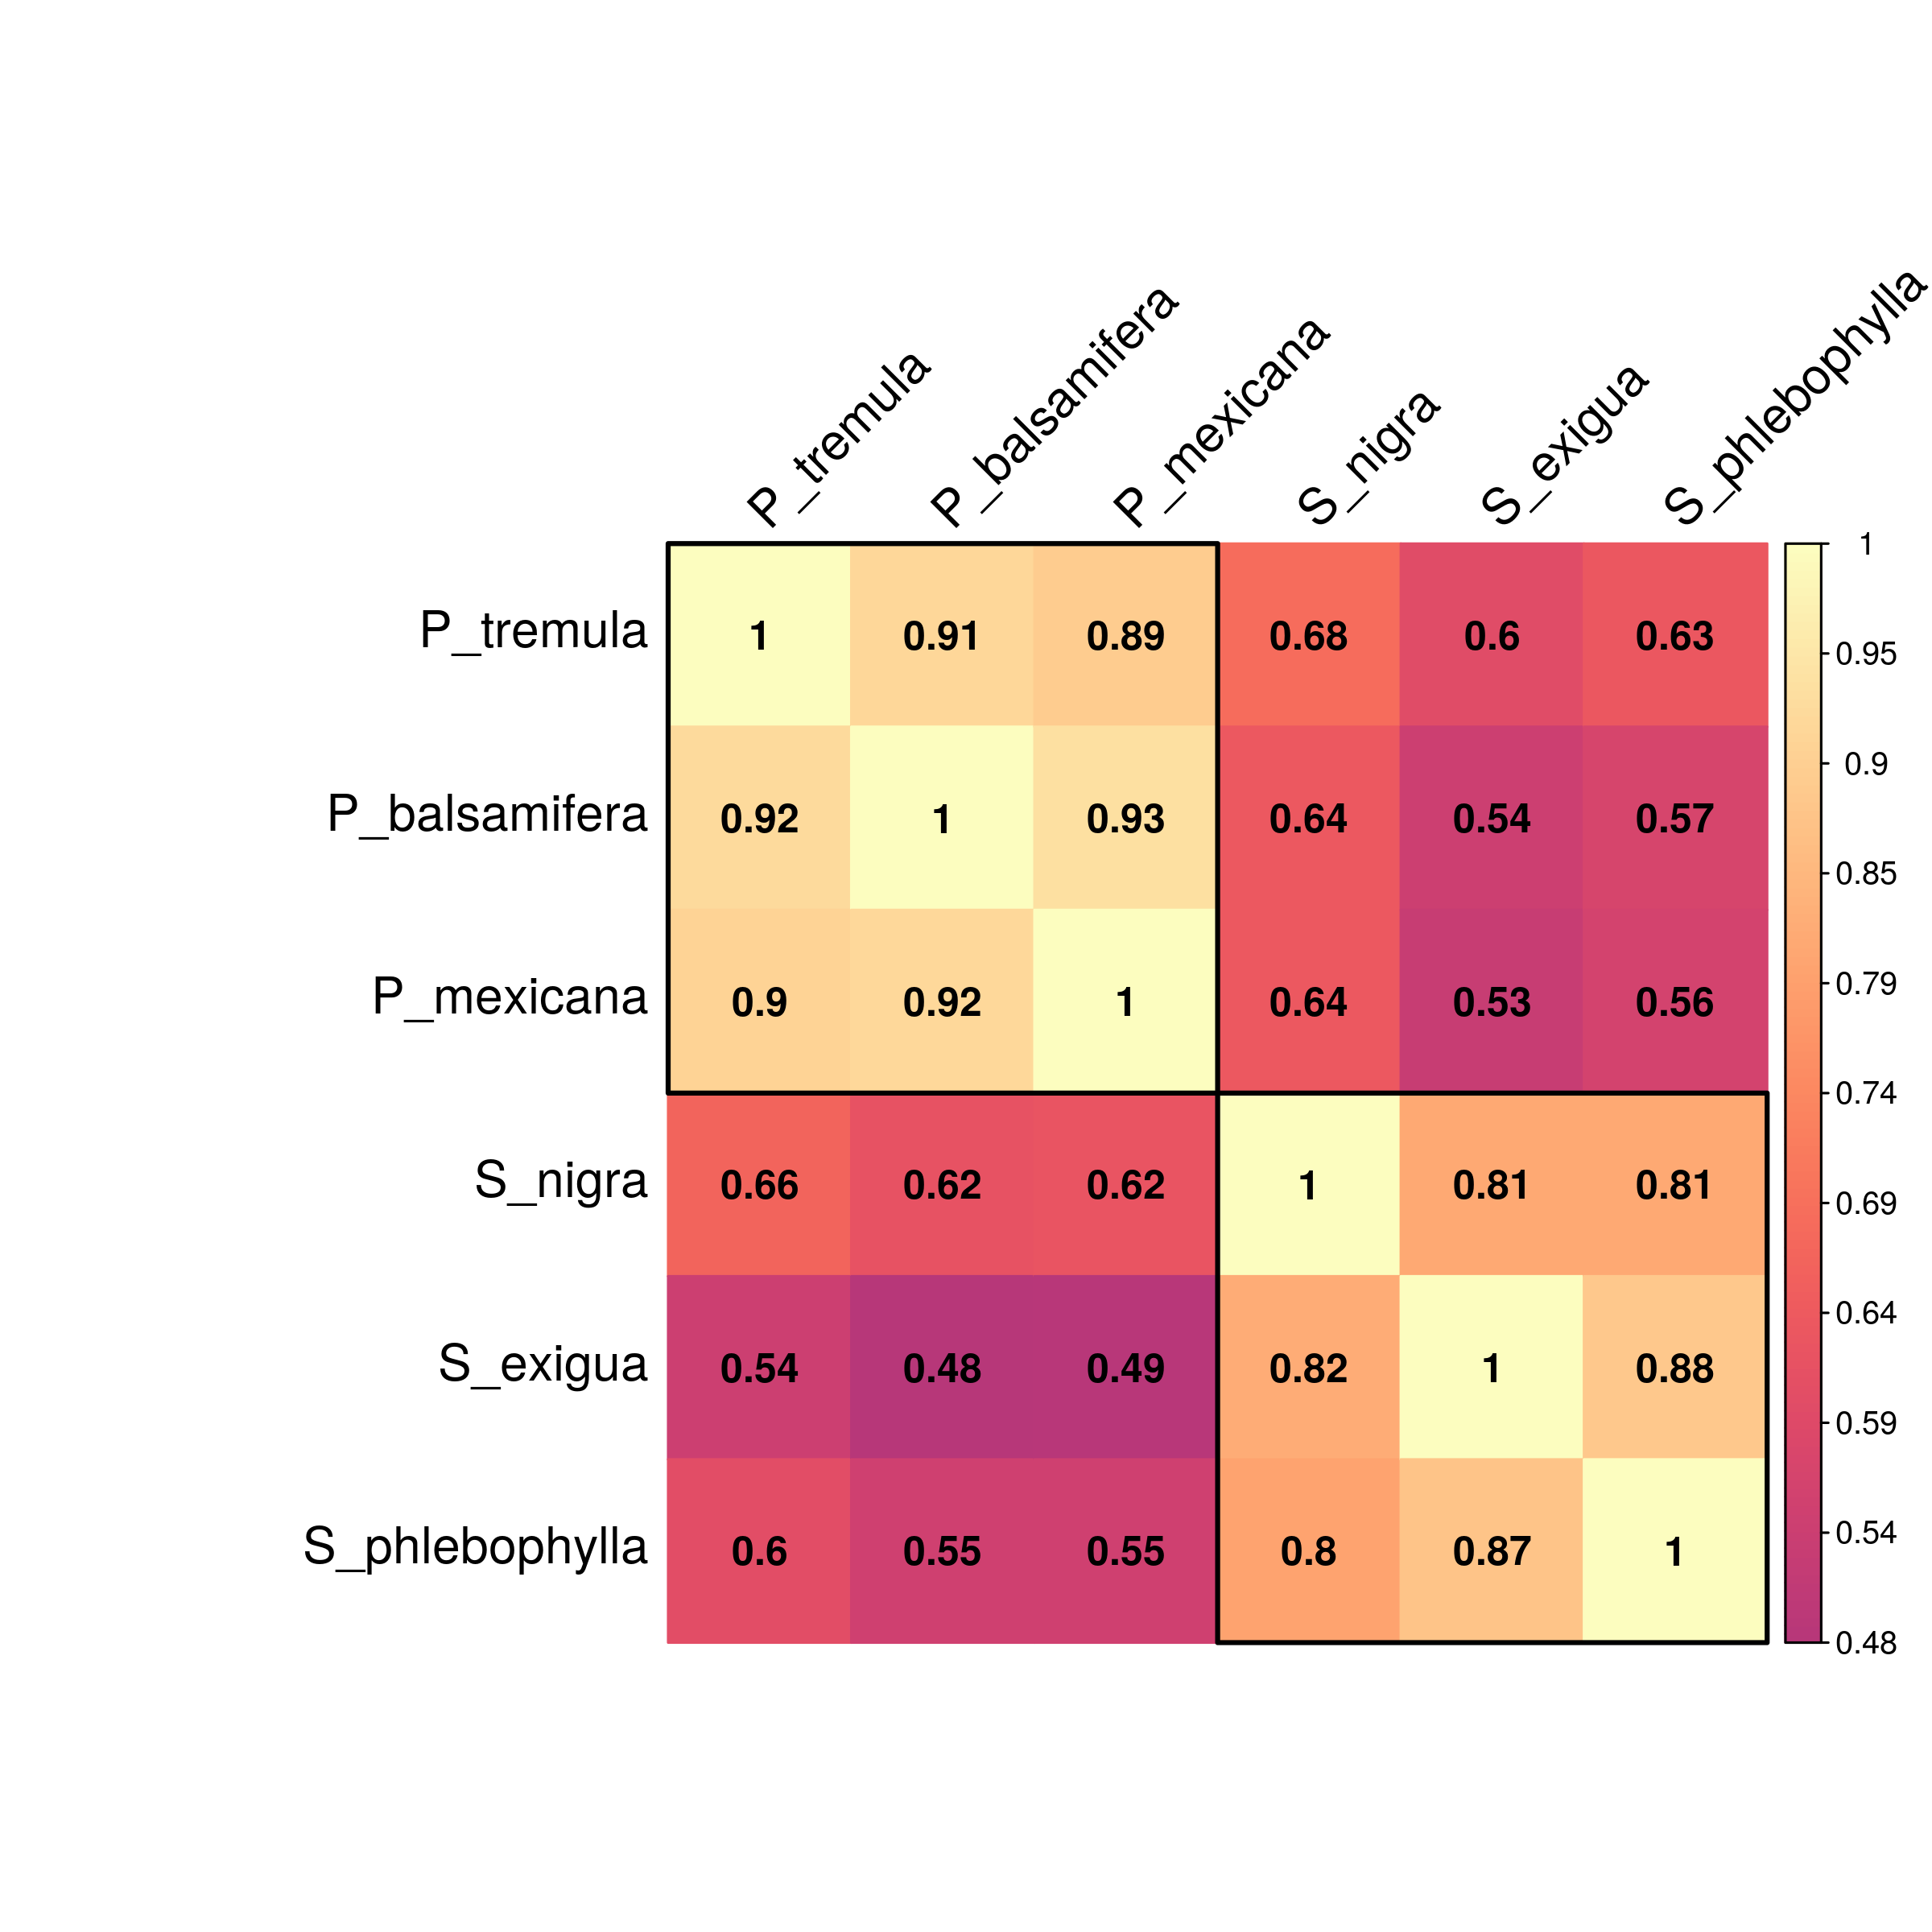

In [13]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 300)
corrplot(piMatrix, order="hclust", is.corr=FALSE, method="color", 
         tl.cex=1.25, tl.col="black", tl.srt=45,col=magma(256),
         addrect=2, addCoef.col="black")